#### Import Required Modules
Below I collect the tools that I will use to build the model. After initial exploratory modeling I found that `XGBClassifier` provided the best performance, measured in terms of model accuracy.  

In [31]:
#Basics
import pandas as pd
import numpy as np

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

#Train Test Split
from sklearn.model_selection import train_test_split

# Imputer
from sklearn.impute import SimpleImputer

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    FunctionTransformer)

# Classifiers
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

#Pipeline
from sklearn.pipeline import Pipeline

#Grid Search
from sklearn.model_selection import GridSearchCV

# Model evaluation
from sklearn.metrics import plot_confusion_matrix

#### Set Random State
There are a few steps below where random processes require a seed. For reproducibility, I set a default random state below.  

In [32]:
random_state = 42

#### Select Columns to Drop from the Model
Provide a list of variables that should be dropped from the model. I have not observed any improvement in model performance from dropping data, measured in terms of accuracy. Training time is obviously improved by dropping columns but there seems to be a small price to pay in terms of accuracy for reducing the number of available features.

In [33]:
drop_cols = []

#### Import Data
Because of the submission format requirements for the competition, it is vital that I retain the index column through out modeling so that I are able to produce predictions that can be validated using the competition's validation data.

In [34]:
features = pd.read_csv(
    filepath_or_buffer='../input/drivendata-pump-it-up/training_features.csv', 
    index_col='id'
)
targets = pd.read_csv(
    filepath_or_buffer='../input/drivendata-pump-it-up/training_labels.csv', 
    index_col='id'
                     )
df = features.join(targets, how='left')
X = df.drop('status_group', axis=1)
y = df['status_group']

#### Make Test Train Split
For the purposes of model tuning I hold 10% of the data out for local testing.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.1, 
    random_state=random_state
)

#### Data Validation
I experimented with both manual and automated feature selection, hoIver neither approach improved model performance. Initially, I had issues with mixed data types in both the `public_meeting` and `permit` columns. The function below converts all categorical variables to strings to eliminate thoes errors. 

In [36]:
def convert_categorical_to_string(data):
    return pd.DataFrame(data).astype(str)

CategoricalTypeConverter = FunctionTransformer(
    convert_categorical_to_string
)

#### Classify Variables
I will need to pre-process the data in preparation for classification. Pre-processing is different for categorical and numerical variables. In order to implement different pre-pricessing flows, I must first classify all of the variables as categorical or numerical. The function below separates columns into these two classes and excludes any variables that will be dropped from the model.

In [37]:
def classify_columns(df, drop_cols):
    """Takes a dataframe and a list of columns to 
    drop and returns:
        - cat_cols: A list of categorical columns.
        - num_cols: A list of numerical columns.
    """
    cols = df.columns
    keep_cols = [col for col in cols if col not in drop_cols]
    cat_cols = []
    num_cols = []
    for col in keep_cols:
        if df[col].dtype == object:
            cat_cols.append(col)
        else:
            num_cols.append(col)
    return cat_cols, num_cols

In [38]:
cat_cols, num_cols = classify_columns(X_train, drop_cols)

### Build Preprocessor
Below I build a preprocessing step for the pipeline which handles all data processing.

#### Categorical Preprocessing Pipeline
The pipeline below executes the following three steps for all of the categorical data.
1. Convert all values in categorical columns to strings. This avoids data type errors in the following steps.
2. Fill all missing values with the string `missing`.
3. One-hot encode all categorical variables. Because this data contains categorical variables with many possible values, it is possible to encounter values in testing data that was not present in the training data. For this reason, I need to set `handel_unknown` to `ignore` so that the encoder will simply ignore unknown values in testing data.

In [39]:
categorical_pipeline = Pipeline(
    steps=[
        (
            'typeConverter', 
            CategoricalTypeConverter
        ),
        (
            'imputer', 
            SimpleImputer(
                strategy='constant', 
                fill_value='missing'
            )
        ),
        (
            'standardizer', 
            OneHotEncoder(
                handle_unknown='ignore',
                dtype=float
            )
        )
    ]
)

#### Numerical Preprocessing Pipeline
The pipeline below executes two steps:
1. Imputes missing values in any numerical column with the median value from that column.
2. Scales each variable to have mean zero and standard deviation one.

In [40]:
numerical_pipeline = Pipeline(
    steps=[
        (
            'imputer', 
            SimpleImputer(
                strategy='median'
            )
        ),
        (
            'standardizer', 
            StandardScaler()
        )
    ]
)

#### Preprocessing Pipeline
The column transformer below implements each of the three possible pre-processing behaviors. 
1. Apply the categorical pipeline.
2. Apply the numerical pipeline.
3. Drop the specified columns.
The if-then statement below ensures that the drop processor is only implemented if there are columns to drop. This is needed since passing an empty `drop_col` list throws an error.

In [41]:
if len(drop_cols) > 0:
    preprocessor = ColumnTransformer(
        transformers=[
            (
                'numericalPreprocessor', 
                numerical_pipeline, 
                num_cols
            ),
            (
                'categoricalPreprocessor', 
                categorical_pipeline, 
                cat_cols
            ),
            (
                'dropPreprocessor', 
                'drop', 
                drop_cols
            )
        ]
    )
else:
    preprocessor = ColumnTransformer(
        transformers=[
            (
                'numericalPreprocessor', 
                numerical_pipeline, 
                num_cols
            ),
            (
                'categoricalPreprocessor', 
                categorical_pipeline, 
                cat_cols
            )
        ]
    )

### Build Model Pipeline
Below I build the main pipeline which executes two steps.
1. Apply preprocessing to the raw data.
2. Fit a one vs rest classifier to the processed data using an eXtreme Gradient Boosted forest model.

In [42]:
pipeline = Pipeline(
    steps=[
        (
            'preprocessor', 
            preprocessor
        ),
        (
            'classifier', 
            OneVsRestClassifier(
                estimator='passthrough'
            )
        )
    ]
)

### Building Parameter Grid
Below I define a grid of hyper-parameters for the pipeline that will be tested in a grid search below.

In [43]:
from catboost import CatBoostClassifier

In [44]:
parameter_grid = [
    {
        'classifier__estimator': [
            XGBClassifier()
        ],
        'classifier__estimator__max_depth': [
            20
        ],
        'classifier__estimator__n_estimators': [
            800
        ]
    }
]

### Instantiate Grid Search
Below I instantiate a grid search object which will fit the pipeline for every combination of the parameters defined above. Since the competition uses accuracy as it's measure of model quality, I sill evaluate model performance in terms of accuracy. For each parameter combination, the grid search will also execute five-fold cross validation. 

In order to maximize performance, I will fit the grid search on the full provided training data set and select the best hyper-parameters based on the results of cross validation. For the purposes of local model evaluation, I will then refit the best model on the local training data and use the local testing data to produce a confusion matrix.

In [45]:
grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=parameter_grid, 
    scoring='accuracy', 
    cv=5, 
    verbose=1, 
    n_jobs=-2,
    refit=True
)

### Fit Grid Search
Below I fit the grid search on the full training set and select the best model hyper-parameters. This step takes an Extremely long time to run.

In [46]:
grid_search.fit(
    X, y
)
model = grid_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed: 47.2min finished


### Display Results of Grid Search
Below I display the results of the grid search. I pay particular attention to `std_test_score` which will become larger if the model is over-fit. 

In [47]:
grid_search_results = pd.DataFrame(
    grid_search.cv_results_
)
grid_search_results.to_csv(
    './grid_search_results.csv'
)

In [48]:
grid_search_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0    1449.010916    222.881974         10.58772        0.542391   

                         param_classifier__estimator  \
0  XGBClassifier(base_score=None, booster=None, c...   

  param_classifier__estimator__max_depth  \
0                                     20   

  param_classifier__estimator__n_estimators  \
0                                       800   

                                              params  split0_test_score  \
0  {'classifier__estimator': XGBClassifier(base_s...           0.811616   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.808586           0.804798            0.80362            0.80404   

   mean_test_score  std_test_score  rank_test_score  
0         0.806532        0.003091                1

#### Plotting Model Accuracy

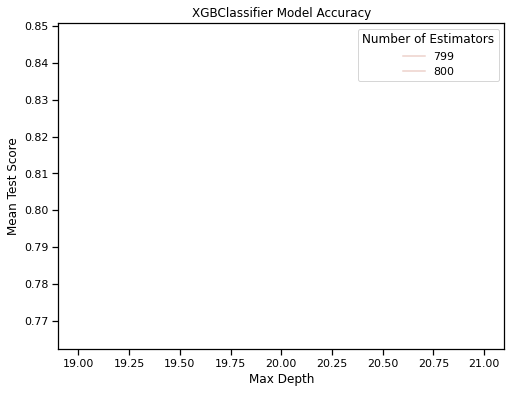

In [49]:
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(8)
sns.lineplot(
    x='param_classifier__estimator__max_depth',
    y='mean_test_score', 
    hue='param_classifier__estimator__n_estimators',
    data=grid_search_results,
    ax=ax
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles[1:], 
    labels=labels[1:], 
    title="Number of Estimators"
);
ax.set_xlabel(
    'Max Depth'
);
ax.set_ylabel(
    'Mean Test Score'
);
ax.set_title(
    'XGBClassifier Model Accuracy'
);
fig.savefig(
    'Model_Accuracy.png', 
    bbox_inches='tight'
)

#### Plotting Fit Time

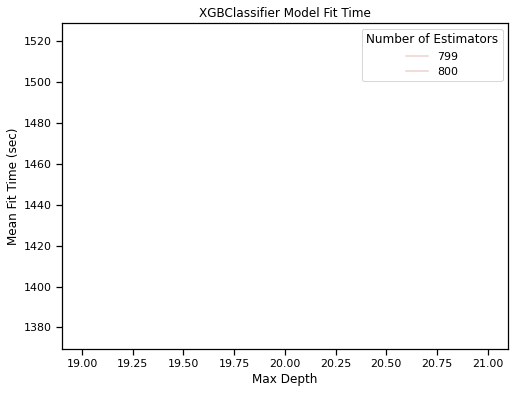

In [50]:
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(8)
sns.lineplot(
    x='param_classifier__estimator__max_depth',
    y='mean_fit_time', 
    hue='param_classifier__estimator__n_estimators',
    data=grid_search_results,
    ax=ax
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles[1:],
    labels=labels[1:], 
    title="Number of Estimators"
);
ax.set_xlabel(
    'Max Depth'
);
ax.set_ylabel(
    'Mean Fit Time (sec)'
);
ax.set_title(
    'XGBClassifier Model Fit Time'
);
fig.savefig(
    'Model_Fit_Time.png', 
    bbox_inches='tight'
)

### Predict on Validation Data
Below I import the testing data provided by the competition. To maximize performance I refit the model on the full training data set. Predictions are formatted and saved to CSV for submission.

In [51]:
X_validate = pd.read_csv(
    '../input/drivendata-pump-it-up/testing_features.csv', 
    index_col='id'
)
y_validate = model.predict(
    X_validate
)
df_predictions = pd.DataFrame(
    y_validate, 
    index=X_validate.index, 
    columns=['status_group']
)
df_predictions.to_csv(
    'Submission.csv'
)

### Produce Confusion Matrix
Below I fit the model on the local training data and produce a confusion matrix using the local test data. This provides a reasonable indication of how the model performs. Because the model needs to be fit before producing the matrix, this step will take a long time to run.

#### Refitting Model on Local Training Set

In [ ]:
model.fit(
    X_train, 
    y_train
)

#### Computing Confusion Matrix on Local Testing Set

In [ ]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
plot_confusion_matrix(
    model, X_test, 
    y_test, 
    ax=ax, 
    normalize='true', 
    include_values=True
)
fig.savefig(
    'Confusion_Matrix.png', 
    bbox_inches='tight'
)

### Confusion Matrix Analysis
I can see that accuracy is worst on the 'functional needs repair' group as I would expect. This class is under represented in the data and is most likely somewhat ambiguously defined in comparison to the other classifications. 

### Future Work
The two most promising directions for further work seem to be:
1. Integrating re-sampling into the pipeline to improve accuracy on the 'functional needs repair' class.
2. Implementing hierarchical models or stacked models.